# NMR Inversion Recovery Analysis in Python

<strong>Author(s):</strong> Seth D. Veenbaas, Jessica A. Nash, The Molecular Sciences Software Institute

<div class="alert alert-block alert-info"> 
<h2>Overview</h2>

<strong>Objective:</strong>

* Use Pandas and Scipy to proceed NMR data.

* Use Matplotlib to visualize data.

* Calculate the T<sub>1</sub> relaxation times.

* Calculate an ideal d<sub>1</sub> delay time.

</div>

## Inversion recovery experiment
The inversion-recovery experiment measures $T_1$ relaxation times of any nucleus. If the net magnetization is placed along the -z axis, it will gradually return to its equilibrium position along the +z axis at a rate governed by $T_1$. The equation governing this behavior as a function of the time t after its displacement is: 

$$ M_z(t) = M_{z,\text{eq}} \cdot \left(1 - 2e^{-t/T_1}\right) $$

The basic pulse sequence consists of an 180<sup>°</sup> pulse that inverts the magnetization to the -z axis. During the following delay, relaxation along the longitudinal plane takes place. Magnetization comes back to the original equilibrium z-magnetization. A 90<sup>°</sup> pulse creates transverse magnetization. The experiment is repeated for a series of delay values taken from a variable delay list. A 1D spectrum is obtained for each value of vd and stored in a pseudo 2D dataset. The longer the relaxation delay (d<sub>1</sub>) is, the more precise the T<sub>1</sub> measurement is. An ideal relaxation time (d<sub>1</sub>) can be calculated (aq = acquisition time):

 $$ d_1 + \text{aq} = 5 \cdot T_1 $$

 <br>

![image.png](images/t1_relaxation_pulse_sequence.png)

More information:
https://imserc.northwestern.edu/downloads/nmr-t1.pdf



## Importing Required Libraries

First, let's import the python libraries/packages we need to work with the data.


In [18]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import mnova
import rdkit
from rdkit.Chem import Draw

# Enable inline plotting
%matplotlib inline

# Set DataFrame precision to 3 decimal places
pd.set_option("display.precision", 3)


## Inversion recovery of ibuprofen

We will be analyzing <sup>13</sup>C inversion recovery from ibuprofen today.

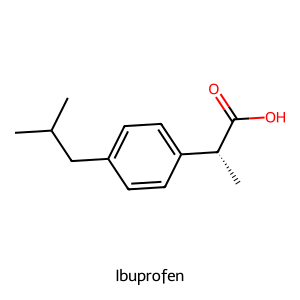

In [19]:
ibuprofen = rdkit.Chem.MolFromSmiles('CC(C)Cc1ccc(cc1)[C@@H](C)C(=O)O')
Draw.MolToImage(ibuprofen, legend='Ibuprofen')

## Importing the Data

We will now import the NMR inversion recovery data from a CSV file to a Pandas Dataframe (the excel of Python).

The file `Ibuprofen-C13-invrec-data-mnova.csv` contains the experimental data from an inversion recovery experiment for ibuprofen.

In [20]:
# Load the data from the CSV file
ibuprofen_inversion_data = pd.read_csv('data/Ibuprofen-C13-invrec-data-mnova.csv', header=1)

# Display the first 5 row of the dataframe
ibuprofen_inversion_data.head()

,#,X(I),Y(X),Y'(X),Y1(X),Y1'(X),Y2(X),Y2'(X),Y3(X),Y3'(X),Y4(X),Y4'(X),Y5(X),Y5'(X),Y6(X),Y6'(X),Y7(X),Y7'(X),Unnamed: 18
0,Model,ARR_DATA(I),"Integral(184.95960620,182.35769533)",B+F*exp(-x*G)\r\nB= -249.719\r\nF= -4239.1\r\n...,"Integral(144.35402748,142.46172866)",B+F*exp(-x*G)\r\nB= 723.715\r\nF= -6792.85\r\n...,"Integral(140.56942985,138.12521055)",B+F*exp(-x*G)\r\nB= 2759.37\r\nF= -8738.66\r\n...,"Integral(132.92138881,131.73870205)",B+F*exp(-x*G)\r\nB= 4368.65\r\nF= -10389.5\r\n...,"Integral(131.02909000,129.60986588)",B+F*exp(-x*G)\r\nB= 5042.5\r\nF= -10478.3\r\nG...,"Integral(80.88317142,77.72934006)",B+F*exp(-x*G)\r\nB= 7.38875e+09\r\nF= -7.38877...,"Integral(48.47755423,46.58525541)",B+F*exp(-x*G)\r\nB= 3910.67\r\nF= -7197.97\r\n...,"Integral(26.40073473,23.32574915)",B+F*exp(-x*G)\r\nB= 1886.51\r\nF= -4687.87\r\n...,NaN
1,1,0.06250000,-4684.67491755,-4468.27273173,-5499.79491631,-5775.77668958,-5036.19281657,-5904.98586705,-6258.79620623,-5737.30320982,-5560.29537629,-5216.24212910,-27060.48190796,-24076.49667168,-1331.85901880,-2992.05818250,-2792.25325529,-2431.18329529,NaN
2,2,0.12500000,-3658.10880536,-4447.82371496,-6311.52026068,-5495.08503925,-5046.87077057,-5831.30498975,-5070.04392764,-5461.52442705,-5501.24326624,-5001.29476755,-21971.77474004,-23972.87635136,-2232.15717667,-2708.92638200,-718.40139958,-2090.23654339,NaN
3,3,0.25000000,-3931.38608140,-4407.22257458,-4594.11075216,-4969.54466647,-6585.52637099,-5685.81763374,-4965.12272888,-4932.33846124,-4204.97791338,-4584.81680598,-22386.95381022,-23765.63571453,-4227.64711944,-2177.02638569,-2714.23372112,-1486.98561249,NaN
4,4,0.50000000,-3852.76993758,-4327.19449393,-3103.07623043,-4047.94829549,-4563.78488370,-5402.19290033,-3098.56823670,-3957.89565420,-3719.21397954,-3802.95406153,-22592.48742043,-23351.15445614,-2123.34892575,-1238.01032740,-399.04734850,-541.13166503,NaN


### Use the `mnova.rename_columns()` function to reformat the Dataframe.

The format will make the data easier to work will.

|        Time(s)         |           <#>_ppm            |
| :--------------------: | :--------------------------: |
| Time of scan (seconds) | Chemical shift of each peak. |

In [21]:
# Runs reformating function
ibuprofen_inversion_data = mnova.rename_columns(ibuprofen_inversion_data)

# Display the first 5 row of the dataframe
ibuprofen_inversion_data.head()

,Time(s),183.7_ppm,143.4_ppm,139.3_ppm,132.3_ppm,130.3_ppm,47.5_ppm,24.9_ppm
1,0.062,-4684.675,-5499.795,-5036.193,-6258.796,-5560.295,-1331.859,-2792.253
2,0.125,-3658.109,-6311.520,-5046.871,-5070.044,-5501.243,-2232.157,-718.401
3,0.250,-3931.386,-4594.111,-6585.526,-4965.123,-4204.978,-4227.647,-2714.234
4,0.500,-3852.770,-3103.076,-4563.785,-3098.568,-3719.214,-2123.349,-399.047
5,1.000,-4292.297,-3898.902,-6335.422,-3270.550,-2361.015,600.839,234.864


<div class="alert alert-block alert-warning">
<h3>Challange</h3>

Use `plot()` to visualize the inversion recovery signals in `ibuprofen_inversion_data`.

**Tip**: plot `Time(s)` on the x-axis.

</div>

### [`DataFrame.plot()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)

Make plots of a DataFrame.

#### Parameters

- **x** : `str` of column name, *(default: `None`)*

    The column to use for the x-axis (independent variable).

- **y** : `str` or `list` of column name(s), *(default: `None`)*

    The column(s) to use for the y-axis (dependent variable).

- **kind** : `str`, *(Default: `'line'`)*

    The kind of plot to produce (e.g., `'bar'`, `'hist'`, `'scatter'`)

<Axes: xlabel='Time(s)'>

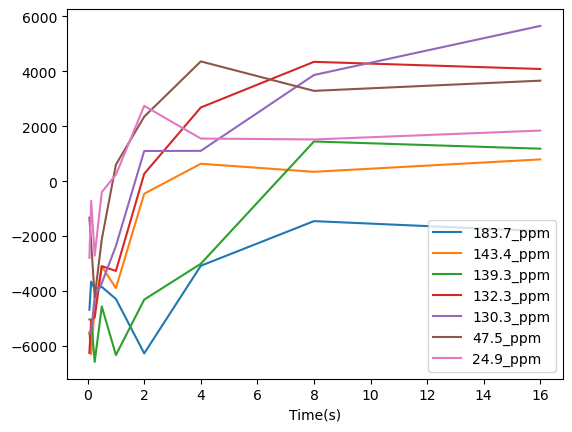

In [22]:
# Plot the data from all peaks vs. Time(s)
ibuprofen_inversion_data.plot(x='Time(s)')

## Calculate $T_1$ relaxation time

We will use the `curve_fit()` function from scipy to fit our data to the exponential inversion recovery model:

$$
M_z(t) = {\color{red} M_{z,\text{eq}}} \cdot \left(1 - 2e^{-t/{\color{red} T_1}}\right) + {\color{red} C}
$$

The `curve_fit()` function with optimize the three parameters in our inversion recovery model using our experimental data.

$$
parameters = {\color{red} M_{z,\text{eq}}}, {\color{red} T_1}, {\color{red} C}

$$

<br>

Let's use `curve_fit()` with our data from the peak at 143.4 ppm to determine an optimal value for $T_1$!

In [23]:
# Extract data for the peak at 143.4 ppm
time_data = ibuprofen_inversion_data['Time(s)']
peak_data = ibuprofen_inversion_data['143.4_ppm']

# Define the inversion recovery model with the parameters (M, T1, and C)
def inversion_recovery_model(time, M, T1, C):
    return M * (1 - 2 * np.exp(-time / T1)) + C

# Initial guess for our three parameters (M, T1, and C)
initial_guess = [max(peak_data), 1, min(peak_data )]

# Fit the curve to get optimized parameters (M, T1, and C)
param_optimal, _ = curve_fit(inversion_recovery_model, time_data, peak_data, p0=initial_guess)

# Print optimized parameters
print(param_optimal)


[ 3.39642570e+03  1.41574198e+00 -2.67269822e+03]


To get 

## Code reusability: calculate $T_1$ for all peaks

Great, We calculated $T_1$! Now just 6 more peaks to go....

Don't worry, we can reuse our code to do repetitive tasks if we design it properly.

Two really powerful tools for reusing code are:
- defining custom functions
- `for` loops

## How to Define a Function
1. **Keyword**: Use the `def` keyword to start the definition.  
2. **Name**: Choose a descriptive name for the function (e.g., `calculate_energy`).  
3. **Parameters**: Enclose optional input parameters in parentheses `()`.  
4. **Colon**: Add a colon `:` to indicate the start of the function body.  
5. **Indented Body**: Write the function's logic as an indented block (4 spaces).  
6. **Optional Return**: Use `return` to send a result back to the caller (if needed).
7. **Optional Docstring**: Explains what a function does, what the parameters are, and what the function returns (if any).


### Here is what it looks like to define a function:
```python
def function_name(parameters):
    # Optional: explain what your function does in a Docstring
    """
    Docstring
    """
    # Function body (indented code)
    return output  # Optional: Return a result
```
<br>

Let's create a function that we can reuse to plot our fitted data!

In [24]:
def plot_fitted_data(df, time_col, peak_col, param_optimal):
    """
    Plots the peak intensity vs. time data along with the fitted inversion recovery model.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing the data to be plotted.
    - time_col (str): The column name in the DataFrame representing time data.
    - peak_col (str): The column name in the DataFrame representing peak intensity data.
    - param_optimal (np.ndarray): Optimal parameters from the curve fitting (M_z,eq, T1, C) returned by `curve_fit`.

    Returns:
    - None: This function directly displays the plot using `matplotlib.pyplot.show()`.

    The function creates a scatter plot of the peak intensity vs. time and overlays a curve fit based on the 
    inversion recovery model. The fitted T1 value is displayed in the plot legend.
    """
    time_data = df[time_col]
    peak_data = df[peak_col]
    
    # Create a blank figure
    plt.figure(figsize=(8, 6))
    
    # Plot peak intensity vs. time as a scatter plot
    plt.scatter(time_data, peak_data, label=f'{peak_col} Data')
    
    # Plot curve fit
    x_model = np.linspace(min(time_data), max(time_data), 100)
    y_model = inversion_recovery_model(x_model, *param_optimal)
    plt.plot(x_model, y_model, label=f'Fit: T1 = {param_optimal[1]:.3f} s', color='red')
    
    # Add labels, title, and legend
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Signal intensity', fontsize=12)
    plt.title(f'Inversion Recovery Fit for peak {peak_col}',  fontsize=14)
    plt.legend(loc='lower right')
    
    # Show the plot
    plt.show()


<div class="alert alert-block alert-warning">
<h3>Challange</h3>

Create a custom function that performs a curve fit to our inversion recovery model. You do not need to write a doc string but do incorporate the following:

#### 1. Function Name: `fit_relaxation_data`

#### 2. Parameters:

- `time_data` (list): Time points for the relaxation curve.
- `peak_data` (list): Corresponding peak intensities.

#### 3. Function body (indented code):

```python
# Initial guess for our three parameters (M, T1, and C)
initial_guess = [max(peak_data), 1, min(peak_data )]

# Fit the curve to get optimized parameters (M, T1, and C)
param_optimal, _ = curve_fit(inversion_recovery_model, time_data, peak_data, p0=initial_guess)
```

#### 4. Return:

- `param_optimal` (ndarray) Optimal parameters for the inversion recovery model (M_z,eq, T1, C)

</div>


In [25]:
# Write the custom function `fit_relaxation_data`
def fit_relaxation_data(time_data, peak_data):
    # Initial guess for M, T1, and C
    initial_guess = [max(peak_data), 1.0, min(peak_data)]
    
    # Fit the curve
    param_optimal, _ = curve_fit(inversion_recovery_model, time_data, peak_data, p0=initial_guess)
    
    return param_optimal

## How to Write a for Loop
1. **Keyword**: Start with `for`.
2. **Iterator Variable**: Specify a variable for each item.
3. **`in` Keyword**: Use in to specify the sequence.
4. **Colon**: Add a colon `:` to start the loop body.
5. **Indented Body**: Indent the code to execute in each iteration.

### Here is what it looks like to write a `for` loop:

```python
for each_item in your_items:
    # Code to be executed for each_item (indented code)
```

<br>

Let's create a `for` loop that:
* Uses `fit_relaxation_data` to fit the data for every peaks.
* Uses `plot_fitted_data` to plot the fit for every peaks.
* Creates a DataFrame called `t1_data` to save the T<sub>1</sub> time for all our peaks.

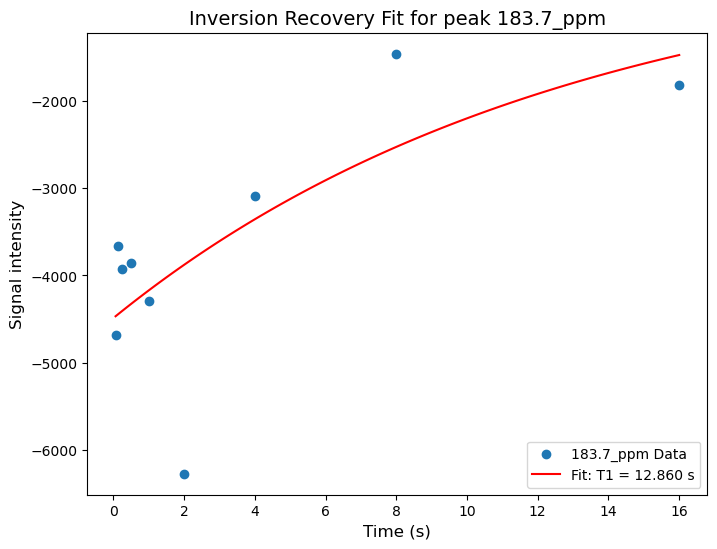

/tmp/ipykernel_328312/2119918285.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  t1_data = pd.concat([t1_data, new_row], ignore_index=True)


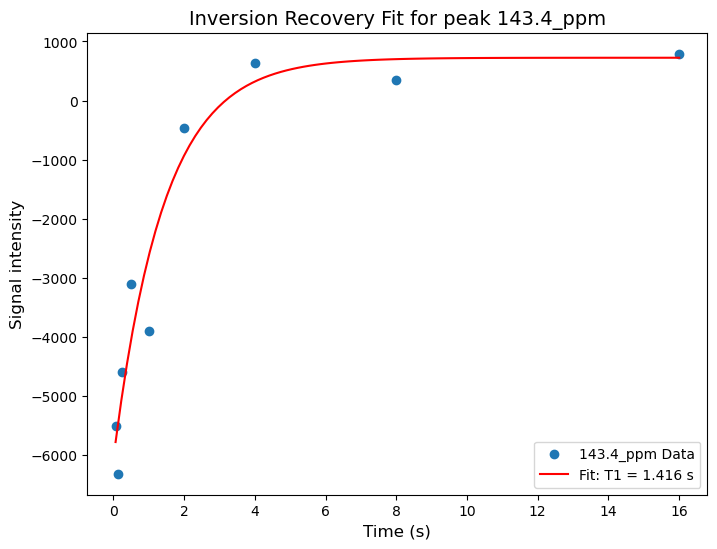

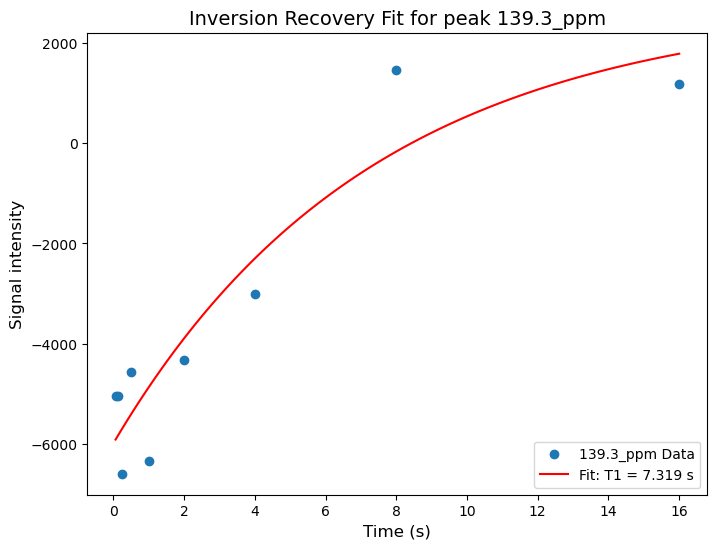

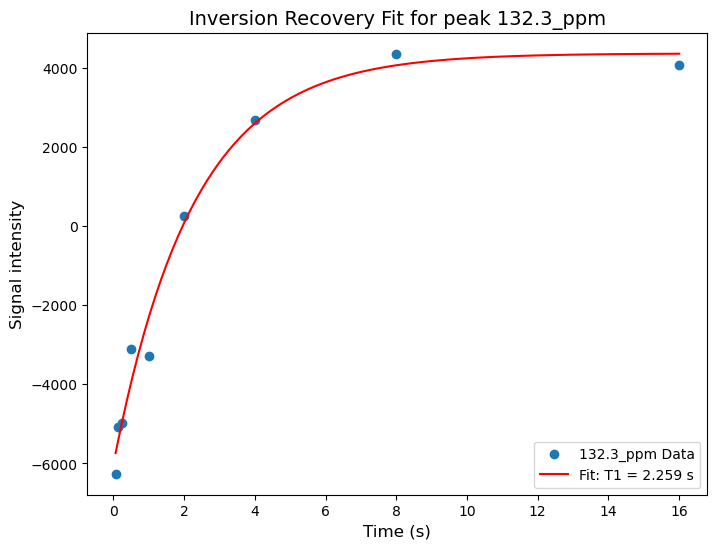

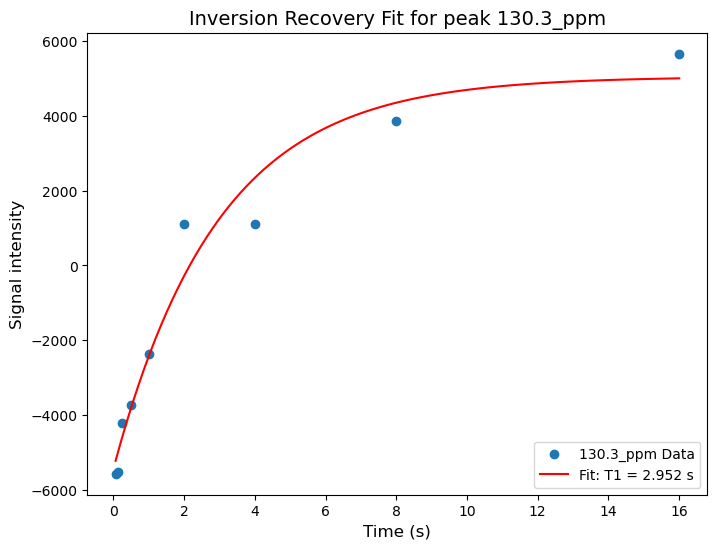

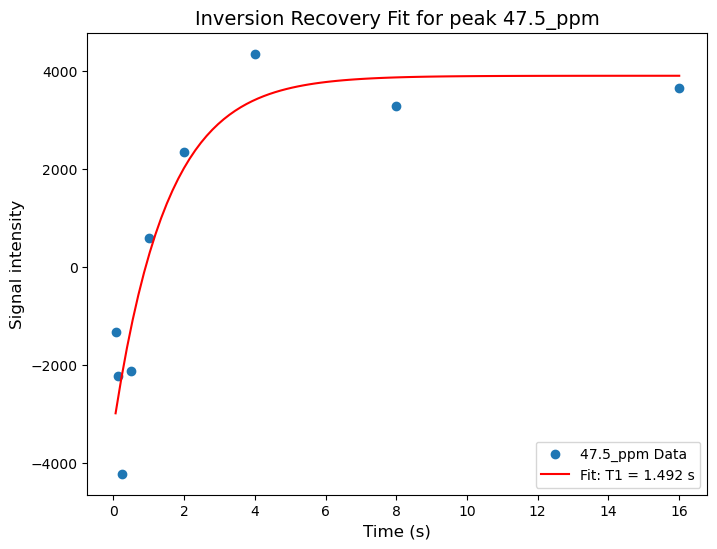

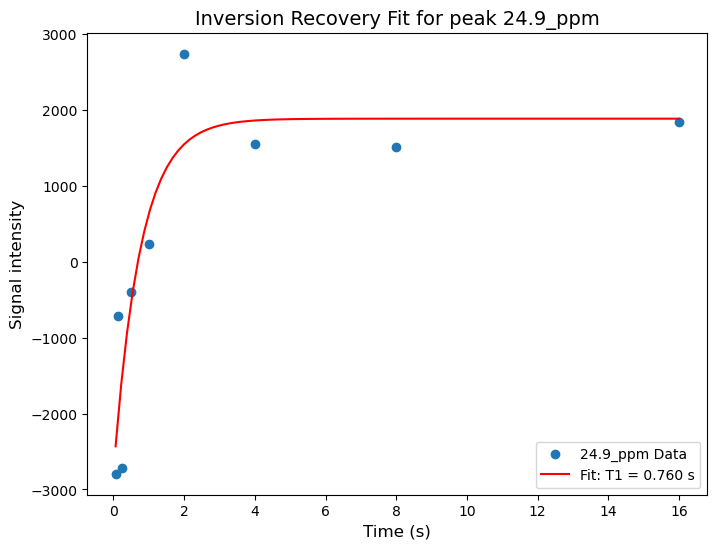

,Peak,T1(s)
0,183.7_ppm,12.860
1,143.4_ppm,1.416
2,139.3_ppm,7.319
3,132.3_ppm,2.259
4,130.3_ppm,2.952
5,47.5_ppm,1.492
6,24.9_ppm,0.760


In [26]:
# Define what DataFrame to use to improve reusability.
df = ibuprofen_inversion_data

# Create an empty DataFrame for t1_data with columns 'Peak' and 'T1(s)'
t1_data = pd.DataFrame(columns=['Peak', 'T1(s)'])

# Calculate T1 for each peak and plot the fit
for column in df.columns[1:]:
    
    # Fit relaxation data to calculate T1
    time_data = df['Time(s)']
    peak_data = df[column]
    param_optimal = fit_relaxation_data(time_data, peak_data)
    T1 = param_optimal[1]
    
    # Plot the fitted data
    plot_fitted_data(df, 'Time(s)', column, param_optimal)
    
    # Add T1 time to the t1_data DataFrame
    new_row = pd.DataFrame({'Peak': [column], 'T1(s)': [T1]})
    t1_data = pd.concat([t1_data, new_row], ignore_index=True)

# Display `t1_data` DataFrame
t1_data


## Calculate Ideal Delay Time ($d_1$)

We can calculate an ideal delay time $d_1$ for future NMR experiments based on the measured $T_1$ times. The relationship is given by the formula:

$ d_1 + \text{aq} = 5 \times T_1 $

or

$ d_1 = (5 \times T_1) - \text{aq} $

Where:
- $d_1$ is the ideal delay time (seconds).
- $\text{aq}$ (acquisition time) = 1.3 seconds (Bruker default for <sup>13</sup>C).
- $T_1$ is the longitudinal relaxation time (seconds).

<br>

<div class="alert alert-block alert-warning">
<h3>Challange</h3>

Use the $T_1 $ times in `t1_data['T1(s)']` to calculate ideal delay times $d_1$ and save the results to `t1_data['D1(s)']`.

Display the `t1_data` DataFrame to check your work.

</div>

In [27]:
# Define the acquisition time (aq)
aq = 1.3

# Calculate D1 delay time using vectorized operations
t1_data['D1(s)'] = (5 * t1_data['T1(s)'] - aq)

# Display Dataframe
t1_data

,Peak,T1(s),D1(s)
0,183.7_ppm,12.860,63.001
1,143.4_ppm,1.416,5.779
2,139.3_ppm,7.319,35.293
3,132.3_ppm,2.259,9.995
4,130.3_ppm,2.952,13.458
5,47.5_ppm,1.492,6.161
6,24.9_ppm,0.760,2.499


## Export results

You can export a DataFrame from pandas to a CSV file using the `DataFrame.to_csv()` method. 

### [DataFrame.to_csv()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html)

Write a DataFrame to a CSV file.

#### Parameters

- **path_or_buf** : `str`, *(default: `None`)*

    The file path or object to write the CSV data. If `None`, the result is returned as a string.

- **index** : `bool`, *(default: `True`)*

    Whether to write row names (index). If `False`, the index is not written.

<br>

Let's export the formatted `ibuprofen_inversion_data` DataFrame!

In [28]:
ibuprofen_inversion_data.to_csv(path_or_buf='results/ibuprofen_inversion_data.csv', index=False)

<div class="alert alert-block alert-warning">
<h3>Challange</h3>

Export the `t1_data` DataFrame to the path `'results/ibuprofen_t1_data.csv'`.

See what happens if you set `index=True`.

</div>

In [29]:
# Export `ibuprofen_t1_data`
t1_data.to_csv(path_or_buf='results/ibuprofen_t1_data.csv', index=True)